In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import tensorflow as tf

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
path_save_spectrogram = 'C:/Users/Steph/#Binus/#Bangkit/#Project/Code/Audio Dataset/CombinedData/Train/spectrogram/'

X_in = np.load(path_save_spectrogram +'noisy_voice_amp_db'+".npy")
X_ou = np.load(path_save_spectrogram +'voice_amp_db'+".npy")

(50, 128, 128)

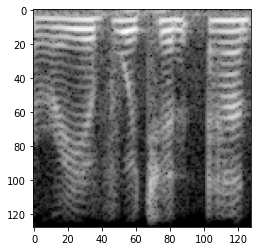

In [4]:
plt.imshow(X_in[0], cmap='gray')
X_in.shape

(50, 128, 128)

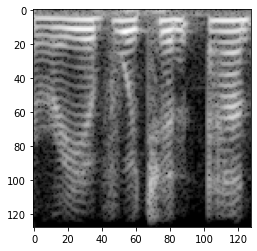

In [5]:
plt.imshow(X_ou[0], cmap='gray')
X_ou.shape

(50, 128, 128, 1)

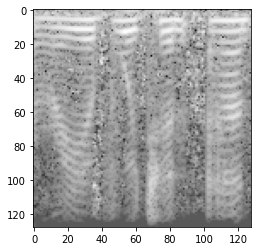

In [35]:
X_ou = X_in - X_ou
plt.imshow(X_ou[0], cmap='gray')
X_ou.shape

In [7]:
def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec

def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 )/82
    return matrix_spec

In [36]:
X_in = scaled_in(X_in)
X_ou = scaled_ou(X_ou)

In [37]:
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.1, random_state=322)

In [11]:
#Unet network
def unet(pretrained_weights = None,input_size = (128,128,1)):
    #size filter input
    size_filter_in = 16
    #normal initialization of weights
    kernel_init = 'he_normal'
    #To apply leaky relu after the conv layer 
    activation_layer = None
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)
    up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)
    up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mae'])

    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [12]:
def mynet(input_size = (128,128,1)):
    size_filter_in = 16
    #normal initialization of weights
    kernel_init = 'he_normal'
    #To apply leaky relu after the conv layer 
    activation_layer = None
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(conv1)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(conv2)
    conv3 = Conv2D(1, 1, activation = 'tanh')(pool2)
    
    model = Model(inputs,conv3)

    model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mae'])
    
    return model

In [39]:
generator_nn=unet()

In [40]:
#generator_nn.summary()

In [47]:
history = generator_nn.fit(X_train, y_train, epochs=10, batch_size=20, shuffle=True, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
3/3 [==============================] - 0s 93ms/step - loss: 1.4817e-04 - mae: 0.0113 - val_loss: 4.7960e-04 - val_mae: 0.0254
Epoch 2/10
3/3 [==============================] - 0s 96ms/step - loss: 1.3808e-04 - mae: 0.0102 - val_loss: 6.2885e-04 - val_mae: 0.0298
Epoch 3/10
3/3 [==============================] - 0s 95ms/step - loss: 1.2528e-04 - mae: 0.0096 - val_loss: 6.4314e-04 - val_mae: 0.0300
Epoch 4/10
3/3 [==============================] - 0s 95ms/step - loss: 1.1255e-04 - mae: 0.0094 - val_loss: 7.3875e-04 - val_mae: 0.0323
Epoch 5/10
3/3 [==============================] - 0s 105ms/step - loss: 1.0167e-04 - mae: 0.0089 - val_loss: 9.5266e-04 - val_mae: 0.0365
Epoch 6/10
3/3 [==============================] - 0s 93ms/step - loss: 9.1001e-05 - mae: 0.0085 - val_loss: 8.4342e-04 - val_mae: 0.0347
Epoch 7/10
3/3 [==============================] - 0s 95ms/step - loss: 8.2986e-05 - mae: 0.0082 - val_loss: 8.9640e-04 - val_mae: 0.0356
Epoch 8/10
3/3 [========================

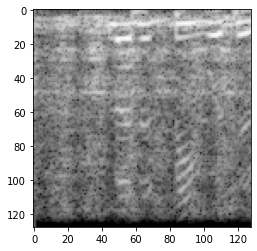

In [42]:
plt.imshow(X_train[0], cmap='gray')

In [43]:
asd = generator_nn.predict(np.array([X_train[0]]))

In [44]:
X_train[0].shape

(128, 128, 1)

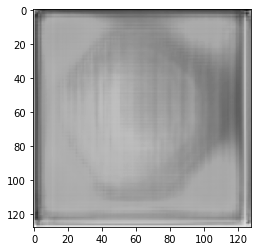

In [45]:
plt.imshow(asd[0], cmap='gray')

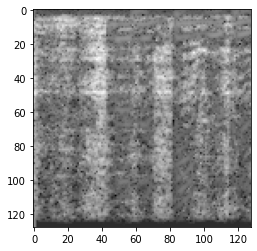

In [46]:
plt.imshow(y_train[0], cmap='gray')